        Month  Diagnosis Count
0  2018-01-01              999
1  2018-02-01              859
2  2018-03-01              983
3  2018-04-01              952
4  2018-05-01              950
5  2018-06-01              943
6  2018-07-01              830
7  2018-08-01              880
8  2018-09-01              774
9  2018-10-01             1030
10 2018-11-01              847
11 2018-12-01              769
12 2019-01-01              824
13 2019-02-01              764
14 2019-03-01              891
15 2019-04-01              913
16 2019-05-01              847
17 2019-06-01              733
18 2019-07-01              775
19 2019-08-01              753
20 2019-09-01              762
21 2019-10-01              839
22 2019-11-01              717
23 2019-12-01              694
24 2020-01-01              794
25 2020-02-01              746
26 2020-03-01              572
27 2020-04-01              296
28 2020-05-01              349
29 2020-06-01              476
30 2020-07-01              516
31 2020-

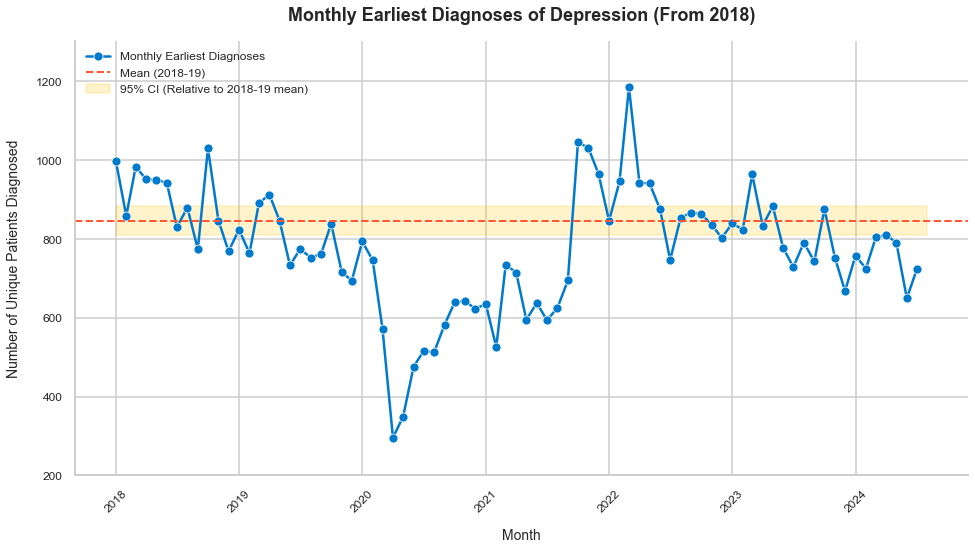

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r'F:\Raine\depression conditions.csv'

data = pd.read_csv(file_path, parse_dates=['CONDITION_START_DATE'], dayfirst=True)

data = data.dropna(subset=['PERSON_ID', 'CONDITION_START_DATE'])

earliest_conditions = data.groupby('PERSON_ID', as_index=False).agg({'CONDITION_START_DATE': 'min'})

earliest_conditions = earliest_conditions[earliest_conditions['CONDITION_START_DATE'] >= '2018-01-01']

assert earliest_conditions['PERSON_ID'].duplicated().sum() == 0, "Duplicate PERSON_IDs found after grouping!"

earliest_conditions['Month'] = earliest_conditions['CONDITION_START_DATE'].dt.to_period('M')

monthly_counts = earliest_conditions.groupby('Month').size()

monthly_counts_df = monthly_counts.reset_index(name='Diagnosis Count')
monthly_counts_df['Month'] = monthly_counts_df['Month'].dt.to_timestamp()
print(monthly_counts_df.to_string())

sns.set(style="whitegrid", context="talk") 
plt.figure(figsize=(16, 8))

monthly_counts_df = monthly_counts_df[0:-1]

sns.lineplot(
    data=monthly_counts_df,
    x='Month',
    y='Diagnosis Count',
    marker='o',
    color='#007ACC',
    linewidth=2.5,
    label='Monthly Earliest Diagnoses'
)

mean_val = monthly_counts_df['Diagnosis Count'][0:24].mean()
std_err = monthly_counts_df['Diagnosis Count'].std() / (len(monthly_counts_df) ** 0.5)
ci_value = 1.96 * std_err 

plt.axhline(mean_val, color='#FF5733', linestyle='--', linewidth=2, label='Mean (2018-19)')
plt.fill_between(monthly_counts_df['Month'], mean_val - ci_value, mean_val + ci_value, 
                 color='#FFC300', alpha=0.2, label='95% CI (Relative to 2018-19 mean)')

plt.title('Monthly Earliest Diagnoses of Depression (From 2018)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Month', fontsize=14, labelpad=15)
plt.ylabel('Number of Unique Patients Diagnosed', fontsize=14, labelpad=15)
plt.ylim(200, monthly_counts_df['Diagnosis Count'].max()*1.1)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=False, loc='upper left')

sns.despine()
plt.show()

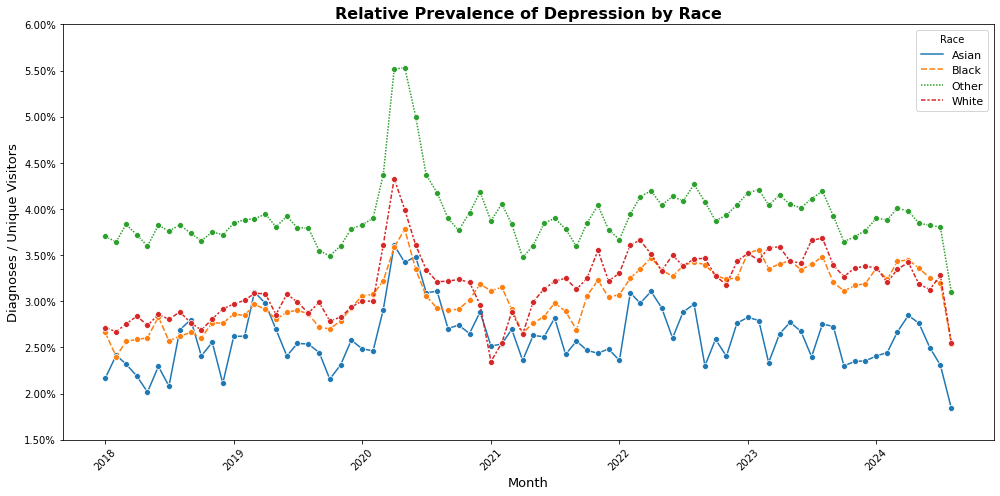

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
# --- Paths to your data files ---
depression_file_path = r'F:\Raine\depression conditions.csv'
visit_files = [
    r'F:\Raine\all_visits_updated.csv',  
]

# ========== STEP 1: READ AND CLEAN DEPRESSION DATA ==========

# Read depression data
depression_data = pd.read_csv(depression_file_path, parse_dates=['CONDITION_START_DATE'], dayfirst=True)
# Drop rows without key info
depression_data.dropna(subset=['PERSON_ID', 'CONDITION_START_DATE'], inplace=True)
# Filter from 2018 onwards
depression_data = depression_data[depression_data['CONDITION_START_DATE'] >= '2018-01-01']
# Create a 'Month' period for grouping
depression_data['Month'] = depression_data['CONDITION_START_DATE'].dt.to_period('M')

# ========== STEP 2: READ AND CLEAN VISIT DATA, MERGE DEMOGRAPHICS ==========

# Read and concatenate all visit files
visit_data = pd.concat([
    pd.read_csv(file, parse_dates=['VISIT_START_DATE'], dayfirst=True)
    for file in visit_files
])

# Drop rows without key info
visit_data.dropna(subset=['PERSON_ID', 'VISIT_START_DATE'], inplace=True)
# Filter from 2018 onwards
visit_data = visit_data[visit_data['VISIT_START_DATE'] >= '2018-01-01']
# Create a 'Month' period for grouping
visit_data['Month'] = visit_data['VISIT_START_DATE'].dt.to_period('M')

# ---
# If your visit_data has the demographic columns (GENDER_CONCEPT_ID, RACE_CONCEPT_ID, ETHNICITY_CONCEPT_ID, AGE)
# for each row, you can use them directly. Otherwise, you might need to extract a unique mapping of PERSON_ID -> demographics.
# For instance, if each person has the same demographics on each visit, you can do:
demo_data = visit_data[['PERSON_ID','RACE_CONCEPT_ID']].drop_duplicates(subset='PERSON_ID')

# Now merge the depression data with these demographics
depression_data = pd.merge(
    depression_data,
    demo_data,
    on='PERSON_ID',
    how='left'  # 'left' ensures we keep all depression_data rows if no demo match found
)

# ========== STEP 3: HELPER FUNCTIONS FOR CATEGORY MAPPINGS ==========

def map_gender(g_id):
    """ Map GENDER_CONCEPT_ID to a label. """
    if g_id == 8507:
        return 'Male'
    elif g_id == 8532:
        return 'Female'

def map_race(r_id):
    """ Map RACE_CONCEPT_ID to a label. """
    if r_id == 8515:
        return 'Asian'
    elif r_id == 8516:
        return 'Black'
    elif r_id == 8527:
        return 'White'
    else:
        return 'Other'

def map_ethnicity(e_id):
    """ Map ETHNICITY_CONCEPT_ID to a label. """
    if e_id == 38003563:
        return 'Hispanic/Latino'
    else:
        return 'Not Hispanic/Latino'

def map_age(age):
    """ Convert numeric age into a category. """
    if pd.isna(age):
        return 'Unknown'
    age = float(age)
    if age < 13:
        return '<13'
    elif 13 <= age <= 17:
        return '13-17'
    elif 18 <= age <= 34:
        return '18-34'
    elif 35 <= age <= 65:
        return '35-65'
    else:
        return '>65'

# Apply these mappings to the depression data
depression_data['RaceCategory']   = depression_data['RACE_CONCEPT_ID'].apply(map_race)


# Also apply these mappings to the visit_data (for grouping total visitors)
visit_data['RaceCategory']   = visit_data['RACE_CONCEPT_ID'].apply(map_race)


# ========== STEP 4: FUNCTION TO CALCULATE AND PLOT PREVALENCE BY A GIVEN CATEGORY ==========

def plot_prevalence_by_category(category_col, title_str, y_lim=None):
    """
    category_col: str - one of ['GenderCategory', 'RaceCategory', 'EthCategory', 'AgeCategory']
    title_str   : str - for the plot title
    y_lim       : tuple or None - y-axis limits if desired
    """

    # 1. Count monthly depression diagnoses by [Month, category]
    #    We want unique PERSON_IDs for each month+category
    monthly_depr_counts = (
        depression_data
        .dropna(subset=[category_col])  # Just in case
        .groupby(['Month', category_col])['PERSON_ID']
        .nunique()
        .reset_index(name='DepressionCount')
    )
    # Convert 'Month' from Period to Timestamp for plotting
    monthly_depr_counts['Month'] = monthly_depr_counts['Month'].dt.to_timestamp()

    # 2. Count monthly visitors by [Month, category]
    monthly_visitors = (
        visit_data
        .dropna(subset=[category_col])  # Just in case
        .groupby(['Month', category_col])['PERSON_ID']
        .nunique()
        .reset_index(name='VisitorCount')
    )
    monthly_visitors['Month'] = monthly_visitors['Month'].dt.to_timestamp()

    # 3. Merge them together on [Month, category_col]
    combined = pd.merge(monthly_depr_counts,
                        monthly_visitors,
                        on=['Month', category_col],
                        how='outer')  # outer ensures we don't lose any month/category combos

    # Fill NaNs with 0 for counts
    combined['DepressionCount'] = combined['DepressionCount'].fillna(0)
    combined['VisitorCount']    = combined['VisitorCount'].fillna(0)

    # 4. Calculate relative prevalence
    combined['RelativePrevalence'] = 0
    mask = combined['VisitorCount'] > 0
    combined.loc[mask, 'RelativePrevalence'] = (
        combined.loc[mask, 'DepressionCount'] / combined.loc[mask, 'VisitorCount']
    )

    # 5. Pivot so each category becomes its own column
    pivoted = combined.pivot(index='Month', columns=category_col, values='RelativePrevalence')

    # ========== PLOTTING ==========
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=pivoted, marker='o')
    plt.title(f'Relative Prevalence of Depression by {title_str}', fontsize=16, weight='bold')
    plt.xlabel('Month', fontsize=13)
    plt.ylabel('Diagnoses / Unique Visitors', fontsize=13)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xticks(rotation=45)
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.legend(title=title_str, fontsize=11)
    plt.tight_layout()
    plt.show()

# 2) Race
plot_prevalence_by_category(
    category_col='RaceCategory',
    title_str='Race',
    y_lim=(0.015, 0.06)  # example limit; adjust as needed
)


In [4]:
len(open(r"F:\Raine\all_visits_updated.csv").readlines())

25945370

In [22]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ------------------------------------------------
# 1. Paths to input files
# ------------------------------------------------
DEPRESSION_FILE_PATH = r'F:\Raine\depression conditions.csv'
VISITS_FILE_PATH = r'F:\SomeFolder\my_visits.csv'  # CSV with columns: PERSON_ID, VISIT_START_DATE
SQLITE_DB_PATH = r'F:\AllMontefiore2024August.sqlite'

# ------------------------------------------------
# 2. Read Depression Data and Process
# ------------------------------------------------
depression_df = pd.read_csv(DEPRESSION_FILE_PATH, parse_dates=['CONDITION_START_DATE'], dayfirst=True)
# Keep only valid rows and filter date >= 2018-01-01
depression_df = depression_df.dropna(subset=['PERSON_ID', 'CONDITION_START_DATE'])
depression_df = depression_df[depression_df['CONDITION_START_DATE'] >= '2018-01-01']
# Extract Month as a Period
depression_df['Month'] = depression_df['CONDITION_START_DATE'].dt.to_period('M')

# Count unique depression diagnoses by month
monthly_depression_counts = depression_df.groupby('Month')['PERSON_ID'].nunique().reset_index()
monthly_depression_counts.columns = ['Month', 'Depression Diagnoses']

# ------------------------------------------------
# 3. Read Visits Data and Process
# ------------------------------------------------
visits_df = pd.read_csv(VISITS_FILE_PATH, parse_dates=['VISIT_START_DATE'], dayfirst=True)
visits_df = visits_df.dropna(subset=['PERSON_ID', 'VISIT_START_DATE'])
visits_df = visits_df[visits_df['VISIT_START_DATE'] >= '2018-01-01']
visits_df['Month'] = visits_df['VISIT_START_DATE'].dt.to_period('M')

# Count unique visitors by month
monthly_visitors = visits_df.groupby('Month')['PERSON_ID'].nunique().reset_index()
monthly_visitors.columns = ['Month', 'Unique Visitors']

# ------------------------------------------------
# 4. Connect to SQLite and pull demographic info
# ------------------------------------------------
conn = sqlite3.connect(SQLITE_DB_PATH)

# We'll build a WHERE clause of unique person_ids from visits + depression
unique_person_ids = set(depression_df['PERSON_ID']).union(set(visits_df['PERSON_ID']))
person_ids_for_query = ",".join(str(pid) for pid in unique_person_ids)

# Query the PERSON table
# Adjust column names if they differ in your schema
query = f"""
SELECT 
    PERSON_ID,
    GENDER_CONCEPT_ID,
    RACE_CONCEPT_ID,
    ETHNICITY_CONCEPT_ID,
    YEAR_OF_BIRTH,
    MONTH_OF_BIRTH,
    DAY_OF_BIRTH  -- optional if you have day_of_birth
FROM PERSON
WHERE PERSON_ID IN ({person_ids_for_query})
"""
demographics_df = pd.read_sql_query(query, conn)
conn.close()

# Some databases store YEAR_OF_BIRTH, MONTH_OF_BIRTH, and possibly DAY_OF_BIRTH
# We'll compute approximate age for each person at each monthly date if needed
# For convenience, store as separate columns:
demographics_df['DOB_Approx'] = demographics_df.apply(
    lambda row: datetime(
        int(row['YEAR_OF_BIRTH']), 
        int(row['MONTH_OF_BIRTH']) if pd.notnull(row['MONTH_OF_BIRTH']) else 1,
        int(row['DAY_OF_BIRTH']) if pd.notnull(row['DAY_OF_BIRTH']) else 1
    )
    if pd.notnull(row['YEAR_OF_BIRTH']) else np.nan, axis=1
)

# Merge demographics into depression/visits data
# We'll do it for both depression_df and visits_df, to track categories
depression_df = pd.merge(
    depression_df, 
    demographics_df, 
    on='PERSON_ID', 
    how='left'
)
visits_df = pd.merge(
    visits_df,
    demographics_df,
    on='PERSON_ID',
    how='left'
)

# ------------------------------------------------
# 5. Helper: compute monthly-level counts by category
# ------------------------------------------------
def monthly_category_counts(df, category_col='GENDER_CONCEPT_ID'):
    """
    Given a DataFrame (either visits or depression),
    group by Month and the desired category column,
    and return the count of unique PERSON_ID in each group.
    """
    grouped = (
        df
        .groupby(['Month', category_col])['PERSON_ID']
        .nunique()
        .reset_index()
    )
    grouped.columns = ['Month', category_col, 'Unique_Count']
    return grouped

# Get monthly depression counts by GENDER/RACE/ETHNICITY
dep_by_gender = monthly_category_counts(depression_df, 'GENDER_CONCEPT_ID')
dep_by_race = monthly_category_counts(depression_df, 'RACE_CONCEPT_ID')
dep_by_ethn = monthly_category_counts(depression_df, 'ETHNICITY_CONCEPT_ID')

# Get monthly visitors (denominator) by GENDER/RACE/ETHNICITY
vis_by_gender = monthly_category_counts(visits_df, 'GENDER_CONCEPT_ID')
vis_by_race   = monthly_category_counts(visits_df, 'RACE_CONCEPT_ID')
vis_by_ethn   = monthly_category_counts(visits_df, 'ETHNICITY_CONCEPT_ID')

# Convert Period to Timestamp for easier plotting
for df_ in [dep_by_gender, vis_by_gender, 
            dep_by_race, vis_by_race, 
            dep_by_ethn, vis_by_ethn]:
    df_['Month'] = df_['Month'].dt.to_timestamp()

# ------------------------------------------------
# 6. Define category filters (concept IDs of interest)
# ------------------------------------------------
gender_map = {
    8507: 'Male',
    8532: 'Female'
}
race_map = {
    8515: 'Asian',
    8516: 'Black',
    8527: 'White'
}
ethn_map = {
    38003563: 'Hispanic',
    38003564: 'Not Hispanic'
}

# ------------------------------------------------
# 7. Function to calculate and plot relative prevalence
# ------------------------------------------------
def plot_relative_prevalence(dep_df, vis_df, valid_concepts, concept_map, title_prefix):
    """
    For each concept ID in `valid_concepts`, compute monthly relative prevalence,
    then plot all lines on a single figure. Also compute 2018-2019 mean/CI.
    """
    
    # Filter to only the relevant concept IDs
    dep_df = dep_df[dep_df[dep_df.columns[1]].isin(valid_concepts)].copy()
    vis_df = vis_df[vis_df[vis_df.columns[1]].isin(valid_concepts)].copy()

    # Merge the monthly depression counts with the monthly visitor counts
    # on both Month + category columns
    merged = pd.merge(
        dep_df,
        vis_df,
        on=['Month', dep_df.columns[1]],  # 'GENDER_CONCEPT_ID' / 'RACE_CONCEPT_ID' / etc
        suffixes=('_dep', '_vis'),
        how='outer'
    )
    merged.fillna(0, inplace=True)
    
    # Calculate relative prevalence = unique depression diagnoses / unique visitors
    merged['Relative Prevalence'] = (
        merged['Unique_Count_dep'] / merged['Unique_Count_vis'].replace({0: np.nan})
    )
    
    # Keep only valid months (drop rows where Unique_Count_vis == 0)
    merged = merged[merged['Unique_Count_vis'] > 0]
    
    # We'll group by concept ID and plot them on the same figure
    # For the 2018-19 mean, define a mask
    # (Months from 2018-01 to 2019-12 inclusive)
    date_mask_2018_19 = (merged['Month'] >= '2018-01-01') & (merged['Month'] <= '2019-12-31')

    # Start plotting
    sns.set(style="whitegrid", context="talk")
    plt.figure(figsize=(16, 8))
    
    # Plot lines for each category
    for concept_id in valid_concepts:
        label_str = concept_map.get(concept_id, str(concept_id))
        sub_df = merged[merged[merged.columns[1]] == concept_id].copy()
        sub_df.sort_values('Month', inplace=True)
        
        # Plot line
        sns.lineplot(
            data=sub_df,
            x='Month',
            y='Relative Prevalence',
            marker='o',
            linewidth=2,
            label=label_str
        )
    
    # Compute overall mean across the entire set for 2018-19 
    # (If you want a separate mean line for each category, do that inside the loop instead.)
    # For demonstration, we'll do an overall (pooled) 2018-19 mean:
    mean_2018_19 = merged.loc[date_mask_2018_19, 'Relative Prevalence'].mean()
    # 95% CI for that mean (using standard error of the mean approach)
    n_2018_19 = date_mask_2018_19.sum()
    if n_2018_19 > 1:
        std_2018_19 = merged.loc[date_mask_2018_19, 'Relative Prevalence'].std()
        sem_2018_19 = std_2018_19 / np.sqrt(n_2018_19)
        ci_2018_19 = 1.96 * sem_2018_19
    else:
        ci_2018_19 = 0
    
    # Add mean line
    plt.axhline(mean_2018_19, color='red', linestyle='--', linewidth=2, label='Mean (2018-19)')
    plt.fill_between(
        merged['Month'].sort_values().unique(),
        (mean_2018_19 - ci_2018_19),
        (mean_2018_19 + ci_2018_19),
        color='red', alpha=0.1, label='95% CI'
    )

    plt.title(f'Relative Prevalence of Depression Diagnoses by {title_prefix} (2018+)', 
              fontsize=18, weight='bold', pad=20)
    plt.xlabel('Month', fontsize=14, labelpad=15)
    plt.ylabel('Relative Prevalence (Diagnoses per Visitor)', fontsize=14, labelpad=15)
    # Adjust y-limits as needed
    # plt.ylim(0, 0.05)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12, frameon=False, loc='upper left')
    sns.despine()
    plt.show()

# ------------------------------------------------
# 8. Plot the 3 separate relative prevalence charts
# ------------------------------------------------
# 8a. GENDER
plot_relative_prevalence(
    dep_by_gender, 
    vis_by_gender, 
    valid_concepts=[8507, 8532],  # male / female
    concept_map=gender_map,
    title_prefix='Gender'
)

# 8b. RACE
plot_relative_prevalence(
    dep_by_race, 
    vis_by_race, 
    valid_concepts=[8515, 8516, 8527],  # Asian / Black / White
    concept_map=race_map,
    title_prefix='Race'
)

# 8c. ETHNICITY
plot_relative_prevalence(
    dep_by_ethn, 
    vis_by_ethn, 
    valid_concepts=[38003563, 38003564],  # Hispanic / Not Hispanic
    concept_map=ethn_map,
    title_prefix='Ethnicity'
)

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\SomeFolder\\my_visits.csv'

In [ ]:
import csv
import sqlite3
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os

def get_person_info(conn, person_id):
    """
    Fetch GENDER_CONCEPT_ID, RACE_CONCEPT_ID, ETHNICITY_CONCEPT_ID,
    YEAR_OF_BIRTH, MONTH_OF_BIRTH from the PERSON table for a given person_id.
    Returns a dict with the columns or None if not found.
    """
    query = """
    SELECT
        GENDER_CONCEPT_ID,
        RACE_CONCEPT_ID,
        ETHNICITY_CONCEPT_ID,
        YEAR_OF_BIRTH,
        MONTH_OF_BIRTH
    FROM PERSON
    WHERE PERSON_ID = ?
    """

    cursor = conn.execute(query, (person_id,))
    row = cursor.fetchone()
    if row is None:
        return None

    # row is a tuple in the order of columns selected
    return {
        'GENDER_CONCEPT_ID': row[0],
        'RACE_CONCEPT_ID': row[1],
        'ETHNICITY_CONCEPT_ID': row[2],
        'YEAR_OF_BIRTH': row[3],
        'MONTH_OF_BIRTH': row[4]
    }

def calculate_age(visit_date_str, year_of_birth, month_of_birth):
    """
    Compute age (in full years) at visit_date_str, given year and month of birth.
    We assume day of birth is the 1st if only year/month is known.
    """
    if not visit_date_str or not year_of_birth or not month_of_birth:
        return None

    # Convert VISIT_START_DATE to a datetime object.
    # Adjust the parsing if your date format differs.
    try:
        visit_date = datetime.strptime(visit_date_str, "%Y-%m-%d")
    except ValueError:
        # If the date is not in the expected format, return None
        return None

    # Construct approximate birth date (day=1)
    try:
        birth_date = datetime(int(year_of_birth), int(month_of_birth), 1)
    except ValueError:
        return None

    age_delta = relativedelta(visit_date, birth_date)
    return age_delta.years

def main():
    # Set up paths
    input_csv_path = r"F:\Raine\all_visits.csv"
    output_csv_path = r"F:\Raine\all_visits_updated.csv"  # temporary output
    sqlite_path = r"F:\AllMontefiore2024August.sqlite"

    conn = sqlite3.connect(sqlite_path)

    # For best performance, ensure there is an index on PERSON_ID in PERSON table
    # e.g. CREATE INDEX IF NOT EXISTS idx_person_id ON PERSON(PERSON_ID);

    with open(input_csv_path, 'r', newline='', encoding='utf-8') as infile, \
         open(output_csv_path, 'w', newline='', encoding='utf-8') as outfile:

        reader = csv.DictReader(infile)
        # Extend the fieldnames with new columns
        fieldnames = reader.fieldnames + [
            'GENDER_CONCEPT_ID',
            'RACE_CONCEPT_ID',
            'ETHNICITY_CONCEPT_ID',
            'AGE'
        ]
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            person_id_str = row.get("PERSON_ID", "")
            visit_date_str = row.get("VISIT_START_DATE", "")

            # If PERSON_ID is missing or invalid, just write the row as-is (with blanks)
            try:
                person_id = int(person_id_str)
            except ValueError:
                person_id = None

            if person_id is not None:
                # Fetch the relevant info from PERSON table
                pinfo = get_person_info(conn, person_id)
                if pinfo is not None:
                    # Insert those into the row
                    row["GENDER_CONCEPT_ID"] = pinfo['GENDER_CONCEPT_ID']
                    row["RACE_CONCEPT_ID"] = pinfo['RACE_CONCEPT_ID']
                    row["ETHNICITY_CONCEPT_ID"] = pinfo['ETHNICITY_CONCEPT_ID']

                    # Calculate AGE
                    year_of_birth = pinfo['YEAR_OF_BIRTH']
                    month_of_birth = pinfo['MONTH_OF_BIRTH']
                    age = calculate_age(visit_date_str, year_of_birth, month_of_birth)
                    row["AGE"] = age
                else:
                    # If no matching PERSON_ID in the table, fill with None
                    row["GENDER_CONCEPT_ID"] = None
                    row["RACE_CONCEPT_ID"] = None
                    row["ETHNICITY_CONCEPT_ID"] = None
                    row["AGE"] = None
            else:
                # No valid PERSON_ID
                row["GENDER_CONCEPT_ID"] = None
                row["RACE_CONCEPT_ID"] = None
                row["ETHNICITY_CONCEPT_ID"] = None
                row["AGE"] = None

            # Write the updated row
            writer.writerow(row)

    conn.close()

    # OPTIONAL: If you want to overwrite the original CSV with the new one, do:
    # os.remove(input_csv_path)
    # os.rename(output_csv_path, input_csv_path)

if __name__ == "__main__":
    main()


In [ ]:
import csv
import sqlite3
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os

CHUNK_SIZE = 999  # Adjust to your needs. 999 is a common SQLite parameter limit

def calculate_age(visit_date_str, year_of_birth, month_of_birth):
    """
    Compute age (in full years) at visit_date_str, given year and month of birth.
    We assume day of birth is the 1st if only year/month is known.
    """
    if not visit_date_str or not year_of_birth or not month_of_birth:
        return None

    # Convert VISIT_START_DATE to a datetime object
    try:
        visit_date = datetime.strptime(visit_date_str, "%Y-%m-%d")
    except ValueError:
        # If the date format is unexpected, return None
        return None

    # Construct approximate birth date (day=1)
    try:
        birth_date = datetime(int(year_of_birth), int(month_of_birth), 1)
    except ValueError:
        return None

    age_delta = relativedelta(visit_date, birth_date)
    return age_delta.years


def fetch_person_data(conn, person_ids_batch):
    """
    Fetch rows from PERSON for a list of person_ids in one query.
    Returns a dict keyed by PERSON_ID, e.g.:
    {
        1234: {'GENDER_CONCEPT_ID': 8507, 'RACE_CONCEPT_ID': ..., ...},
        5678: {...},
        ...
    }
    """
    # If the list is empty, return an empty dict
    if not person_ids_batch:
        return {}

    # Build the query with placeholders for the IN clause
    # Example: SELECT ... FROM PERSON WHERE PERSON_ID IN (?,?,?)
    placeholders = ",".join("?" for _ in person_ids_batch)
    query = f"""
        SELECT
            PERSON_ID,
            GENDER_CONCEPT_ID,
            RACE_CONCEPT_ID,
            ETHNICITY_CONCEPT_ID,
            YEAR_OF_BIRTH,
            MONTH_OF_BIRTH
        FROM PERSON
        WHERE PERSON_ID IN ({placeholders})
    """

    cursor = conn.execute(query, person_ids_batch)
    rows = cursor.fetchall()

    # Build a dictionary keyed by PERSON_ID
    result_dict = {}
    for row in rows:
        person_id = row[0]
        result_dict[person_id] = {
            'GENDER_CONCEPT_ID': row[1],
            'RACE_CONCEPT_ID': row[2],
            'ETHNICITY_CONCEPT_ID': row[3],
            'YEAR_OF_BIRTH': row[4],
            'MONTH_OF_BIRTH': row[5]
        }

    return result_dict


def process_chunk(chunk, conn, writer, base_fieldnames):
    """
    - Extract unique PERSON_IDs from the chunk.
    - Fetch the corresponding records from PERSON in a single query.
    - For each row in the chunk, compute AGE, and write out to CSV.
    """
    # Gather all person_ids in this chunk (ignoring blanks or invalid)
    person_ids = []
    for row in chunk:
        pid_str = row.get("PERSON_ID", "")
        try:
            pid = int(pid_str)
            person_ids.append(pid)
        except ValueError:
            # Skip invalid PERSON_ID
            continue

    # Fetch all needed PERSON records in one shot
    person_data_dict = fetch_person_data(conn, person_ids)

    # Now go back and enrich each row
    for row in chunk:
        pid_str = row.get("PERSON_ID", "")
        try:
            pid = int(pid_str)
        except ValueError:
            # Invalid PERSON_ID; fill with None
            pid = None

        if pid and pid in person_data_dict:
            pinfo = person_data_dict[pid]
            row["GENDER_CONCEPT_ID"] = pinfo['GENDER_CONCEPT_ID']
            row["RACE_CONCEPT_ID"] = pinfo['RACE_CONCEPT_ID']
            row["ETHNICITY_CONCEPT_ID"] = pinfo['ETHNICITY_CONCEPT_ID']

            # Calculate AGE
            year_of_birth = pinfo['YEAR_OF_BIRTH']
            month_of_birth = pinfo['MONTH_OF_BIRTH']
            visit_date_str = row.get("VISIT_START_DATE", "")
            row["AGE"] = calculate_age(visit_date_str, year_of_birth, month_of_birth)
        else:
            # Not found in PERSON table or invalid PID
            row["GENDER_CONCEPT_ID"] = None
            row["RACE_CONCEPT_ID"] = None
            row["ETHNICITY_CONCEPT_ID"] = None
            row["AGE"] = None

        # Make sure we only write the fields in the correct order
        # (some CSV libraries don't require this, but good practice)
        writer.writerow({fn: row.get(fn, None) for fn in base_fieldnames})


def main():
    input_csv_path = r"F:\Raine\all_visits.csv"
    output_csv_path = r"F:\Raine\all_visits_updated1.csv"
    sqlite_path = r"F:\AllMontefiore2024August.sqlite"

    conn = sqlite3.connect(sqlite_path)
    # For better performance, ensure there's an index on PERSON_ID in the PERSON table:
    # CREATE INDEX IF NOT EXISTS idx_person_id ON PERSON(PERSON_ID);

    with open(input_csv_path, 'r', newline='', encoding='utf-8') as infile, \
         open(output_csv_path, 'w', newline='', encoding='utf-8') as outfile:

        reader = csv.DictReader(infile)
        # Expand fieldnames with new columns
        base_fieldnames = reader.fieldnames + [
            'GENDER_CONCEPT_ID',
            'RACE_CONCEPT_ID',
            'ETHNICITY_CONCEPT_ID',
            'AGE'
        ]
        writer = csv.DictWriter(outfile, fieldnames=base_fieldnames)
        writer.writeheader()

        chunk = []
        for row in reader:
            chunk.append(row)

            # If we've reached the chunk size, process it and reset
            if len(chunk) >= CHUNK_SIZE:
                process_chunk(chunk, conn, writer, base_fieldnames)
                chunk = []

        # Process any leftover rows
        if chunk:
            process_chunk(chunk, conn, writer, base_fieldnames)

    c


In [ ]:
#prevalence relative to visits by month. 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to files
depression_file_path = r'F:\Raine\depression conditions.csv'
visit_files = [
    r'F:\Roham\BC Pandemic (with Hasan)\telehealth.csv',
    r'F:\Roham\BC Pandemic (with Hasan)\outpatient.csv',
    r'F:\Roham\BC Pandemic (with Hasan)\office visit.csv',
    r'F:\Roham\BC Pandemic (with Hasan)\inpatient.csv'
]

# Read and process depression data
data = pd.read_csv(depression_file_path, parse_dates=['CONDITION_START_DATE'], dayfirst=True)
data = data.dropna(subset=['PERSON_ID', 'CONDITION_START_DATE'])
data = data[data['CONDITION_START_DATE'] >= '2018-01-01']
data['Month'] = data['CONDITION_START_DATE'].dt.to_period('M')

# Get unique depression diagnoses per month
monthly_depression_counts = data.groupby('Month')['PERSON_ID']
monthly_depression_df = monthly_depression_counts.reset_index(name='Depression Diagnoses')
monthly_depression_df['Month'] = monthly_depression_df['Month'].dt.to_timestamp()

# Combine visit data from all files
visit_data = pd.concat([pd.read_csv(file, parse_dates=['VISIT_START_DATE'], dayfirst=True) for file in visit_files])
visit_data = visit_data.dropna(subset=['PERSON_ID', 'VISIT_START_DATE'])
visit_data = visit_data[visit_data['VISIT_START_DATE'] >= '2018-01-01']
visit_data['Month'] = visit_data['VISIT_START_DATE'].dt.to_period('M')

# Get unique visitors per month
monthly_visitors = visit_data.groupby('Month')['PERSON_ID'].nunique()
monthly_visitors_df = monthly_visitors.reset_index(name='Unique Visitors')
monthly_visitors_df['Month'] = monthly_visitors_df['Month'].dt.to_timestamp()

# Merge depression data with visit data
combined_df = pd.merge(monthly_depression_df, monthly_visitors_df, on='Month')

# Calculate relative prevalence
combined_df['Relative Prevalence'] = combined_df['Depression Diagnoses'] / combined_df['Unique Visitors']

combined_df = combined_df[0:-1]

print(combined_df)

# Plot relative prevalence
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(16, 8))

sns.lineplot(
    data=combined_df,
    x='Month',
    y='Relative Prevalence',
    marker='o',
    color='#007ACC',  
    linewidth=2.5,
    label='Relative Prevalence of Depression'
)

# Calculate mean and 95% CI for relative prevalence
mean_val = combined_df['Relative Prevalence'][0:24].mean()
std_err = combined_df['Relative Prevalence'].std() / (len(combined_df) ** 0.5)
ci_value = 1.96 * std_err

plt.axhline(mean_val, color='#FF5733', linestyle='--', linewidth=2, label='Mean (2018-19)')
plt.fill_between(combined_df['Month'], mean_val - ci_value, mean_val + ci_value,
                 color='#FFC300', alpha=0.2, label='95% CI (Relative to 2018-19 mean)')

plt.title('Relative Prevalence of Depression Diagnoses (From 2018)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Month', fontsize=14, labelpad=15)
plt.ylabel('Relative Prevalence (Diagnoses per Visitor)', fontsize=14, labelpad=15)
plt.ylim(0.0275, 0.05)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=False, loc='upper left')

sns.despine()
plt.show()


        Month  Depression Diagnoses  Unique Visitors  Relative Prevalence
0  2018-01-01                  4573           142979             0.031984
1  2018-02-01                  4302           139079             0.030932
2  2018-03-01                  4615           141967             0.032508
3  2018-04-01                  4612           143813             0.032069
4  2018-05-01                  4770           152401             0.031299
..        ...                   ...              ...                  ...
74 2024-03-01                  5603           151214             0.037053
75 2024-04-01                  5616           151495             0.037071
76 2024-05-01                  5583           156070             0.035772
77 2024-06-01                  4893           139256             0.035137
78 2024-07-01                  5061           144670             0.034983

[79 rows x 4 columns]


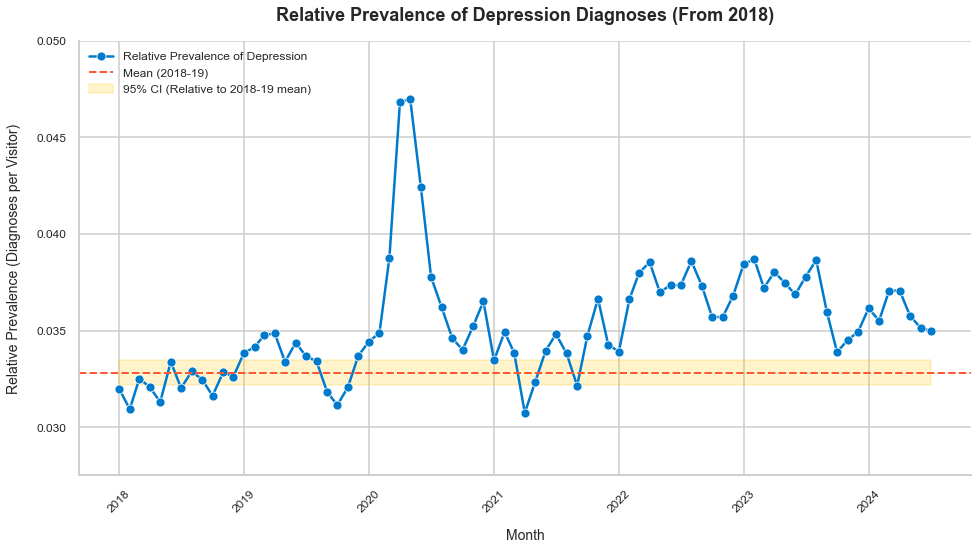

In [145]:
#prevalence relative to visits by month. 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to files
depression_file_path = r'F:\Raine\depression conditions.csv'
visit_files = [
    r'F:\Roham\BC Pandemic (with Hasan)\telehealth.csv',
    r'F:\Roham\BC Pandemic (with Hasan)\outpatient.csv',
    r'F:\Roham\BC Pandemic (with Hasan)\office visit.csv',
    r'F:\Roham\BC Pandemic (with Hasan)\inpatient.csv'
]

# Read and process depression data
data = pd.read_csv(depression_file_path, parse_dates=['CONDITION_START_DATE'], dayfirst=True)
data = data.dropna(subset=['PERSON_ID', 'CONDITION_START_DATE'])
data = data[data['CONDITION_START_DATE'] >= '2018-01-01']
data['Month'] = data['CONDITION_START_DATE'].dt.to_period('M')

# Get unique depression diagnoses per month
monthly_depression_counts = data.groupby('Month')['PERSON_ID'].nunique()
monthly_depression_df = monthly_depression_counts.reset_index(name='Depression Diagnoses')
monthly_depression_df['Month'] = monthly_depression_df['Month'].dt.to_timestamp()

# Combine visit data from all files
visit_data = pd.concat([pd.read_csv(file, parse_dates=['VISIT_START_DATE'], dayfirst=True) for file in visit_files])
visit_data = visit_data.dropna(subset=['PERSON_ID', 'VISIT_START_DATE'])
visit_data = visit_data[visit_data['VISIT_START_DATE'] >= '2018-01-01']
visit_data['Month'] = visit_data['VISIT_START_DATE'].dt.to_period('M')

# Get unique visitors per month
monthly_visitors = visit_data.groupby('Month')['PERSON_ID'].nunique()
monthly_visitors_df = monthly_visitors.reset_index(name='Unique Visitors')
monthly_visitors_df['Month'] = monthly_visitors_df['Month'].dt.to_timestamp()

# Merge depression data with visit data
combined_df = pd.merge(monthly_depression_df, monthly_visitors_df, on='Month')

# Calculate relative prevalence
combined_df['Relative Prevalence'] = combined_df['Depression Diagnoses'] / combined_df['Unique Visitors']

combined_df = combined_df[0:-1]

print(combined_df)

# Plot relative prevalence
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(16, 8))

sns.lineplot(
    data=combined_df,
    x='Month',
    y='Relative Prevalence',
    marker='o',
    color='#007ACC',  
    linewidth=2.5,
    label='Relative Prevalence of Depression'
)

# Calculate mean and 95% CI for relative prevalence
mean_val = combined_df['Relative Prevalence'][0:24].mean()
std_err = combined_df['Relative Prevalence'].std() / (len(combined_df) ** 0.5)
ci_value = 1.96 * std_err

plt.axhline(mean_val, color='#FF5733', linestyle='--', linewidth=2, label='Mean (2018-19)')
plt.fill_between(combined_df['Month'], mean_val - ci_value, mean_val + ci_value,
                 color='#FFC300', alpha=0.2, label='95% CI (Relative to 2018-19 mean)')

plt.title('Relative Prevalence of Depression Diagnoses (From 2018)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Month', fontsize=14, labelpad=15)
plt.ylabel('Relative Prevalence (Diagnoses per Visitor)', fontsize=14, labelpad=15)
plt.ylim(0.0275, 0.05)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=False, loc='upper left')

sns.despine()
plt.show()


        Month  Diagnosis Count
0  2018-01-01             4573
1  2018-02-01             4302
2  2018-03-01             4615
3  2018-04-01             4612
4  2018-05-01             4770
5  2018-06-01             4667
6  2018-07-01             4288
7  2018-08-01             4461
8  2018-09-01             4236
9  2018-10-01             4938
10 2018-11-01             4597
11 2018-12-01             4273
12 2019-01-01             4785
13 2019-02-01             4439
14 2019-03-01             4964
15 2019-04-01             5075
16 2019-05-01             4916
17 2019-06-01             4627
18 2019-07-01             4545
19 2019-08-01             4478
20 2019-09-01             4472
21 2019-10-01             4881
22 2019-11-01             4507
23 2019-12-01             4520
24 2020-01-01             5138
25 2020-02-01             4791
26 2020-03-01             4471
27 2020-04-01             3695
28 2020-05-01             4006
29 2020-06-01             4434
30 2020-07-01             4379
31 2020-

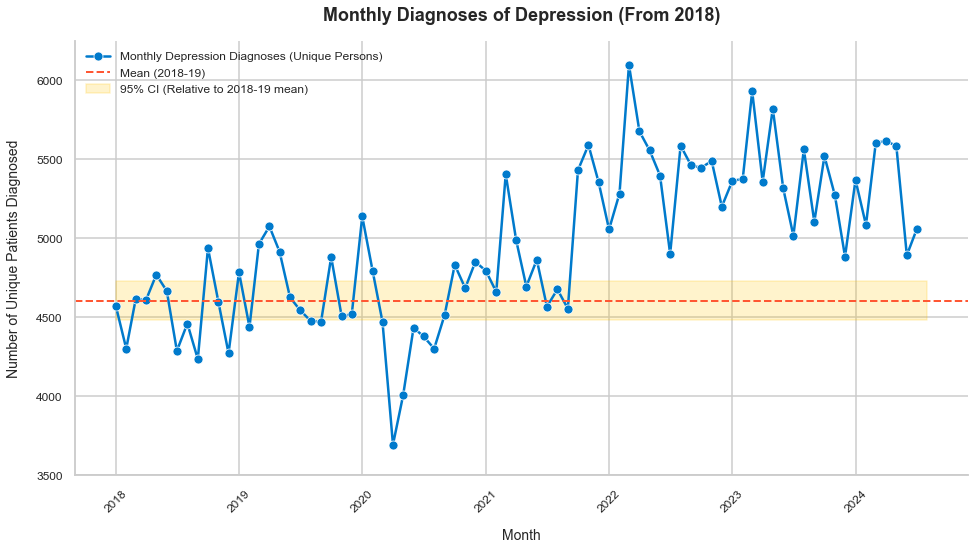

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

depression_file_path = r'F:\Raine\depression conditions.csv'
data = pd.read_csv(depression_file_path, parse_dates=['CONDITION_START_DATE'], dayfirst=True)

data = data.dropna(subset=['PERSON_ID', 'CONDITION_START_DATE'])

data = data[data['CONDITION_START_DATE'] >= '2018-01-01']
data['Month'] = data['CONDITION_START_DATE'].dt.to_period('M')

monthly_counts = data.groupby('Month')['PERSON_ID'].nunique()
monthly_counts_df = monthly_counts.reset_index(name='Diagnosis Count')
monthly_counts_df['Month'] = monthly_counts_df['Month'].dt.to_timestamp()
print(monthly_counts_df.to_string())

sns.set(style="whitegrid", context="talk") 
plt.figure(figsize=(16, 8))

monthly_counts_df = monthly_counts_df[0:-1]

sns.lineplot(
    data=monthly_counts_df,
    x='Month',
    y='Diagnosis Count',
    marker='o',
    color='#007ACC',  
    linewidth=2.5,
    label='Monthly Depression Diagnoses (Unique Persons)'
)

mean_val = monthly_counts_df['Diagnosis Count'][0:24].mean()
std_err = monthly_counts_df['Diagnosis Count'].std() / (len(monthly_counts_df) ** 0.5)
ci_value = 1.96 * std_err 

plt.axhline(mean_val, color='#FF5733', linestyle='--', linewidth=2, label='Mean (2018-19)')
plt.fill_between(monthly_counts_df['Month'], mean_val - ci_value, mean_val + ci_value, 
                 color='#FFC300', alpha=0.2, label='95% CI (Relative to 2018-19 mean)')

plt.title('Monthly Diagnoses of Depression (From 2018)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Month', fontsize=14, labelpad=15)
plt.ylabel('Number of Unique Patients Diagnosed', fontsize=14, labelpad=15)
plt.ylim(3500, 6250)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=False, loc='upper left')

sns.despine()
plt.show()


TypeError: float() argument must be a string or a number, not 'Period'

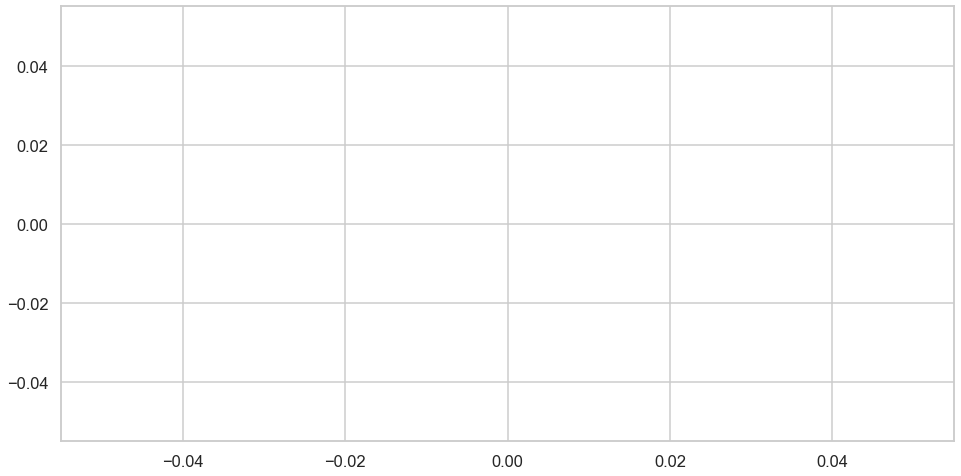

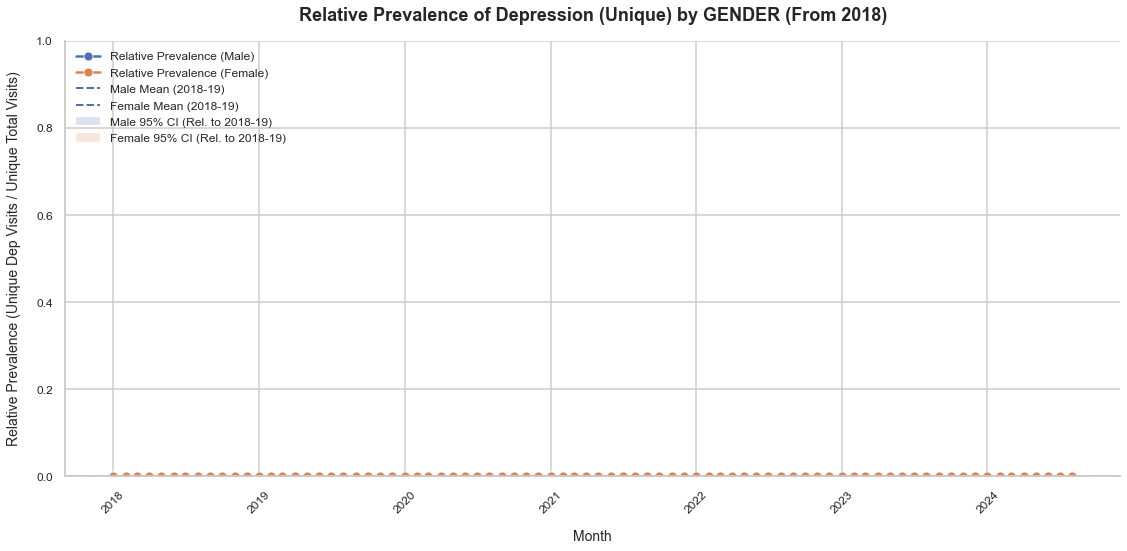

In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# -------------------- Configuration --------------------
db_path = r'F:\AllMontefiore2024August.sqlite'
depression_file_path = r'F:\Raine\depression conditions.csv'
visit_files = [
    r'F:\Roham\BC Pandemic (with Hasan)\telehealth.csv',
    r'F:\Roham\BC Pandemic (with Hasan)\outpatient.csv',
    r'F:\Roham\BC Pandemic (with Hasan)\office visit.csv',
    r'F:\Roham\BC Pandemic (with Hasan)\inpatient.csv'
]
demographic_category = 'GENDER'  # 'RACE' or 'ETHNICITY' if needed
demographic_values = ['Male', 'Female']  # Adjust for RACE or ETHNICITY
# ---------------------------------------------------------

# =====================================================================
# STEP 1: READ & PREP DATA (Depression + Visits) 
# =====================================================================

# -- Depression Data --
dep_data = pd.read_csv(depression_file_path, parse_dates=['CONDITION_START_DATE'], dayfirst=True)
dep_data.dropna(subset=['PERSON_ID', 'CONDITION_START_DATE'], inplace=True)
dep_data = dep_data[dep_data['CONDITION_START_DATE'] >= '2018-01-01']
dep_data['Month'] = dep_data['CONDITION_START_DATE'].dt.to_period('M')

# -- Visit Data (All Types) --
visit_data_list = []
for file in visit_files:
    df = pd.read_csv(file, parse_dates=['VISIT_START_DATE'], dayfirst=True)
    df.dropna(subset=['PERSON_ID', 'VISIT_START_DATE'], inplace=True)
    df = df[df['VISIT_START_DATE'] >= '2018-01-01']
    df['Month'] = df['VISIT_START_DATE'].dt.to_period('M')
    visit_data_list.append(df)

visit_data = pd.concat(visit_data_list, ignore_index=True)

# =====================================================================
# STEP 2: GET DEMOGRAPHICS (GENDER) FROM DATABASE 
# =====================================================================
conn = sqlite3.connect(db_path)

if demographic_category == 'GENDER':
    concept_id_field = 'GENDER_CONCEPT_ID'
elif demographic_category == 'RACE':
    concept_id_field = 'RACE_CONCEPT_ID'
elif demographic_category == 'ETHNICITY':
    concept_id_field = 'ETHNICITY_CONCEPT_ID'
else:
    raise ValueError("Invalid demographic category. Must be 'GENDER', 'RACE', or 'ETHNICITY'.")

# 2A. Map Concept IDs to Names
concept_query = f"""
    SELECT CONCEPT_ID, CONCEPT_NAME
    FROM Concept
    WHERE CONCEPT_ID IN (
        SELECT DISTINCT {concept_id_field}
        FROM Person
    )
"""
concepts_df = pd.read_sql(concept_query, conn)
id_to_category = dict(zip(concepts_df['CONCEPT_ID'], concepts_df['CONCEPT_NAME']))

# 2B. Fetch Person -> Concept IDs in one shot (no placeholders/batches)
#    If your dataset is very large, you might need to chunk this step.
person_query = f"""
    SELECT PERSON_ID, {concept_id_field}
    FROM Person
"""
person_demo_df = pd.read_sql(person_query, conn)
conn.close()

# 2C. Map the numeric concept ID to text (Male, Female, etc.)
person_demo_df[demographic_category] = person_demo_df[concept_id_field].map(id_to_category)
demo_map = dict(zip(person_demo_df['PERSON_ID'], person_demo_df[demographic_category]))

# =====================================================================
# STEP 3: ASSIGN DEMOGRAPHICS TO RECORDS
# =====================================================================
# Map each PERSON_ID to the corresponding gender (or race, or ethnicity)
dep_data[demographic_category] = dep_data['PERSON_ID'].map(demo_map)
visit_data[demographic_category] = visit_data['PERSON_ID'].map(demo_map)

# =====================================================================
# STEP 4: COMPUTE UNIQUE COUNTS & RELATIVE PREVALENCE
# =====================================================================
# For each month & demographic category:
#   Numerator = # of unique PERSON_IDs with a depression visit
#   Denominator = # of unique PERSON_IDs with any visit

# 4A. Depression by category
dep_counts = (
    dep_data
    .groupby(['Month', demographic_category])['PERSON_ID']
    .nunique()  # COUNT UNIQUE PERSON_IDs
    .reset_index(name='Unique_Dep_Visits')
)

# 4B. All visits by category
visit_counts = (
    visit_data
    .groupby(['Month', demographic_category])['PERSON_ID']
    .nunique()  # COUNT UNIQUE PERSON_IDs
    .reset_index(name='Unique_Total_Visits')
)

# 4C. Merge them on Month & demographic
relprev_df = pd.merge(dep_counts, visit_counts, on=['Month', demographic_category], how='outer')

# 4D. Compute ratio
relprev_df['Relative Prevalence'] = (
    relprev_df['Unique_Dep_Visits'] / relprev_df['Unique_Total_Visits']
).fillna(0)

# =====================================================================
# STEP 5: PIVOT FOR PLOTTING
# =====================================================================
# We want columns for each demographic value (Male, Female)
relprev_pivot = relprev_df.pivot(index='Month', columns=demographic_category, values='Relative Prevalence').reset_index()

# Ensure all expected columns exist
for val in demographic_values:
    if val not in relprev_pivot.columns:
        relprev_pivot[val] = 0

# Convert Month from period to timestamp for plotting
relprev_pivot['Month'] = relprev_pivot['Month'].dt.to_timestamp()

# =====================================================================
# STEP 6: PLOT
# =====================================================================
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(16, 8))

# Plot each demographic group (Male, Female)
for val in demographic_values:
    sns.lineplot(
        data=relprev_pivot,
        x='Month',
        y=val,
        marker='o',
        linewidth=2.5,
        label=f'Relative Prevalence ({val})'
    )

# Optionally calculate baseline stats from 2018-2019
baseline = relprev_pivot[relprev_pivot['Month'] < '2020-01-01']

import numpy as np
for val in demographic_values:
    mean_val = baseline[val].mean() if not baseline.empty else 0
    std_err = baseline[val].std() / np.sqrt(len(baseline)) if not baseline.empty else 0
    ci_value = 1.96 * std_err
    plt.axhline(mean_val, linestyle='--', linewidth=2, label=f'{val} Mean (2018-19)')
    plt.fill_between(
        relprev_pivot['Month'],
        mean_val - ci_value,
        mean_val + ci_value,
        alpha=0.2,
        label=f'{val} 95% CI (Rel. to 2018-19)'
    )

plt.title(f'Relative Prevalence of Depression (Unique) by {demographic_category} (From 2018)', 
          fontsize=18, weight='bold', pad=20)
plt.xlabel('Month', fontsize=14, labelpad=15)
plt.ylabel('Relative Prevalence (Unique Dep Visits / Unique Total Visits)', fontsize=14, labelpad=15)
max_val = relprev_pivot[demographic_values].max().max()
plt.ylim(0, max_val * 1.1 if max_val > 0 else 1)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=False, loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()
